# Homework 3

Due date: May 19, 2024

Submission instructions: 
- __Autograder will not be used for scoring, but you still need to submit the python file converted from this notebook (.py) and the notebook file (.ipynb) to the code submission window.__ 
To convert a Jupyter Notebook (`.ipynb`) to a regular Python script (`.py`):
  - In Jupyter Notebook: File > Download as > Python (.py)
  - In JupyterLab: File > Save and Export Notebook As... > Executable Script
  - In VS Code Jupyter Notebook App: In the toolbar, there is an Export menu. Click on it, and select Python script.
- Submit `hw3.ipynb` and `hw3.py` on Gradescope under the window "Homework 3 - code". Do **NOT** change the file name.
- Convert this notebook into a pdf file and submit it on Gradescope under the window "Homework 3 - PDF". Make sure all your code and text outputs in the problems are visible. 


This homework requires two new packages, `pyarrow` and `duckdb`. Pleas make sure to install them in your `BIOSTAT203C-24S` environment:

```bash
conda activate BIOSTAT203C-24S
conda install -c conda-forge pyarrow python-duckdb
```

In [1]:
import sys
import gzip
import time
import random
import duckdb
import numpy as np
import pandas as pd
import polars as pl
import pyarrow as pa
import pyarrow.csv as csv
import pyarrow.compute as pc
import pyarrow.parquet as pq
from matplotlib import pyplot as plt

# Create a syslink named `mimic` in working directory. 
pth_hsp = './mimic/hosp/'
pth_icu = './mimic/icu/'

# Common Objects. Added here in case of kernel crash.
lab_col = ['subject_id', 'itemid', 'charttime', 'valuenum']
lab_itemid = [50912, 50971, 50983, 50902, 50882, 51221, 51301, 50931]

## Problem 1. 

Recall the simple random walk.  At each step, we flip a fair coin. If heads, we move "foward" one unit; if tails, we move "backward." 

### (A).

Way back in Homework 1, you wrote some code to simulate a random walk in Python. 

Start with this code, or use posted solutions for HW1. If you have since written random walk code that you prefer, you can use this instead. Regardless, take your code, modify it, and enclose it in a function `rw()`. This function should accept a single argument `n`, the length of the walk. The output should be a list giving the position of the random walker, starting with the position after the first step. For example, 

```python
rw(5)
[1, 2, 3, 2, 3]
```

Unlike in the HW1 problem, you should not use upper or lower bounds. The walk should always run for as long as the user-specified number of steps `n`. 

Use your function to print out the positions of a random walk of length `n = 10`. 

Don't forget a helpful docstring!

### ANSWER 1A

#### Documentation
rw  takes a positive integer, `n`, and returns a list of all positions from a random walk of `n` steps where each step is decided by a coin flip. If the coin flip results in heads, step forward. If the coin flip results in tails, step backward. The variable, `pos`, is the current position; therefore, append that position after each step.

If n is not an integer or `n` is less than zero, the user will be prompted to enter a new `n`.

In [2]:
def rw(n):
  """
  A list of positions from a random walk.
  ---
  Args:
    n: A positive integer. Number of steps.
  Returns:
    positions: A list of poistions.
  """
  # Input Catch. Must be int.
  while not isinstance(n, int) or n < 0:
    user = input("Enter a positive integer for n: ")
    # try to make users input an int
    try:
        n = int(user)
    # Supply back into the while while loop if error
    except ValueError:
        n
  pos = 0 # Initialized current position
  positions = [] # Empty list. Track positions after a step.
  while len(positions) < n:
    x = random.choice(["heads", "tails"])
    if x == "heads":
        pos += 1 # If heads, move forward one step.
        positions.append(pos) # Append position after step.
    elif x == "tails":
        pos -= 1 # If tails, move backward one step.
        positions.append(pos) # Append position after step.
  return positions

rw(10)

[1, 2, 1, 0, -1, -2, -1, -2, -1, 0]

#### Robustness Test

In [3]:
rw("Oops")

Enter a positive integer for n:  I
Enter a positive integer for n:  did
Enter a positive integer for n:  it
Enter a positive integer for n:  again
Enter a positive integer for n:  4


[-1, 0, 1, 0]

In [4]:
rw(-10)

Enter a positive integer for n:  -2
Enter a positive integer for n:  -10
Enter a positive integer for n:  -12.1
Enter a positive integer for n:  5


[-1, -2, -3, -2, -3]

In [5]:
rw(10.0)

Enter a positive integer for n:  1.2
Enter a positive integer for n:  1.9
Enter a positive integer for n:  2025.
Enter a positive integer for n:  6


[1, 0, 1, 2, 3, 4]

In [6]:
# Comprehensive test. All test in list should result in no errors
tests = [0, 1, 5, 30, 50]
# Store results in a dictionary.
rw_results = dict()
# loop through tests and store in dictionary
for test in tests:
  # label for the values
  name = f"{test} Random Positions"
  # Store the result in the dictionary
  rw_results[name] = rw(test)

# Loop through dictionary and print the results in a readable format
# also print the length of the object
for key, val in rw_results.items():
  print(f"{key} (length = {len(val)}):\n{val}")

0 Random Positions (length = 0):
[]
1 Random Positions (length = 1):
[1]
5 Random Positions (length = 5):
[-1, -2, -1, 0, 1]
30 Random Positions (length = 30):
[-1, -2, -1, 0, -1, -2, -3, -4, -3, -2, -3, -4, -5, -4, -3, -2, -3, -2, -1, -2, -3, -2, -1, -2, -3, -4, -5, -6, -7, -8]
50 Random Positions (length = 50):
[1, 2, 1, 2, 1, 0, 1, 2, 3, 2, 1, 2, 3, 4, 5, 4, 5, 6, 5, 6, 5, 6, 7, 8, 7, 8, 7, 6, 5, 6, 5, 6, 5, 6, 7, 6, 7, 6, 5, 4, 3, 2, 3, 2, 3, 2, 3, 4, 5, 4]


### (B). 

Now create a function called `rw2(n)`, where the argument `n` means the same thing that it did in Part A. Do so using `numpy` tools. Demonstrate your function as above, by creating a random walk of length 10. You can (and should) return your walk as a `numpy` array. 

**Requirements**: 

- No for-loops. 
- This function is simple enough to be implemented as a one-liner of fewer than 80 characters, using lambda notation. Even if you choose not to use lambda notation, the body of your function definition should be no more than three lines long. Importing `numpy` does not count as a line. 
- A docstring is required if and only if you take more than one line to define the function. 

**Hints**:

- Check the documentation for `np.random.choice()`. 
- `np.cumsum()`. 


### Answer 1B

#### Documentation
`rw2` is a lambda function that uses numpy to perform the same operations as `rw`. Because of numpy's vast number of methods that can be applied on a numpy array, the function was able to be simplified into one line without the input catch error. `rw2` uses the numpy and random libraries to create an array of -1 and 1 with replacement which signify a coin flip of heads and tails. The cumulative sum of the numpy array acts like the current position of the random walk.

In [7]:
# Return positions from n random steps
# random choice is used like a coin flip 1=heads -1=tails
# cumsum is used to get the position after each step.
rw2 = lambda n: np.random.choice([-1, 1], size=n, replace=True).cumsum()

rw2(10)

array([-1,  0,  1,  2,  3,  2,  3,  4,  3,  2])

In [8]:
# list of error free tests because rw2 does not have an input catch.
tests = [0, 1, 5, 30, 50]
# store results in dictionary
rw_results = dict()
# loop through the tests and store the results in the dictionary
for test in tests:
  name = f"{test} Random Positions"
  rw_results[name] = rw2(test)
# loop thought the dictionary and print the results in a readable format.
# Also output the length of the object.
for key, val in rw_results.items():
  print(f"{key} (length = {len(val)}):\n{list(val)}")

0 Random Positions (length = 0):
[]
1 Random Positions (length = 1):
[-1]
5 Random Positions (length = 5):
[-1, -2, -1, 0, 1]
30 Random Positions (length = 30):
[1, 0, 1, 2, 3, 2, 1, 0, 1, 0, -1, -2, -3, -4, -3, -2, -3, -4, -3, -4, -3, -4, -5, -6, -5, -4, -5, -6, -5, -4]
50 Random Positions (length = 50):
[1, 0, -1, 0, -1, 0, 1, 2, 1, 0, -1, 0, 1, 0, 1, 2, 1, 0, 1, 2, 3, 4, 3, 2, 1, 0, 1, 0, -1, 0, -1, -2, -3, -2, -1, -2, -1, 0, -1, -2, -3, -4, -5, -4, -3, -2, -3, -2, -3, -4]


### (C).

Use the `%timeit` magic macro to compare the runtime of `rw()` and `rw2()`. Test how each function does in computing a random walk of length `n = 10000`. 

### Answer 1C

In [9]:
%%timeit
rw(10_000)

2.31 ms ± 4.98 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
%%timeit
rw(1_000)

231 µs ± 708 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:
%%timeit
rw(100)

22.9 µs ± 48 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [12]:
%%timeit
rw2(10_000)

42.7 µs ± 33.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [13]:
%%timeit
rw2(1_000)

12.2 µs ± 21 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [14]:
%%timeit
rw2(100)

9.8 µs ± 1.19 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### (D). 

Write a few sentences in which you comment on (a) the performance of each function and (b) the ease of writing and reading each function. 

### ANSWER 1D

The function, `rw2()`, was 82% faster than the function, `rw()`. Built-in python list operations were used in `rw()` and numpy array operations were used in `rw2()`. The average run-times for `rw()` and `rw2()` were 61.1 µs and 362 µs, respectively. The numpy array function, `rw2()`, was easier to write, occupying only one line, and was more readable than the built-in python list operations in `rw()`.

For robustness, multiple values of an were supplied to the functions to test if different lengths resulted in differing results. from this test numpy was always significantly faster than using base python functions.

### (E). 


In this problem, we will perform a `d`-dimensional random walk. There are many ways to define such a walk. Here's the definition we'll use for this problem: 

> At each timestep, the walker takes one random step forward or backward **in each of `d` directions.** 

For example, in a two-dimensional walk on a grid, in each timestep the walker would take a step either north or south, and then another step either east or west. Another way to think about is as the walker taking a single "diagonal" step either northeast, southeast, southwest, or northwest. 

Write a function called `rw_d(n,d)` that implements a `d`-dimensional random walk. `n` is again the number of steps that the walker should take, and `d` is the dimension of the walk. The output should be given as a `numpy` array of shape `(n,d)`, where the `k`th row of the array specifies the position of the walker after `k` steps. For example: 

```python
P = rw_d(5, 3)
P
```
```
array([[-1, -1, -1],
       [ 0, -2, -2],
       [-1, -3, -3],
       [-2, -2, -2],
       [-1, -3, -1]])
```

In this example, the third row `P[2,:] = [-1, -3, -3]` gives the position of the walk after 3 steps. 

Demonstrate your function by generating a 3d walk with 5 steps, as shown in the example above. 

All the same requirements and hints from Part B apply in this problem as well. It should be possible to solve this problem by making only a few small modifications to your solution from Part B. If you are finding that this is not possible, you may want to either (a) read the documentation for the relevant `numpy` functions more closely or (b) reconsider your Part B approach. 





### Answer 1E

#### Documentation
`rw_d` uses the numpy library to list positions from a multi directional random walk. It takes two values. `d` describes the number of directions. `n`, describes the number of steps in each direction. Both `d` and `n` must be positive integers, but if positive integers are not supplied then the user is prompted to enter a new set. The biggest difference between `rw_d` and `rw2` is that the array is reshaped into the correct shape and a cumulative sum is applied along the vertical axis. 

In [102]:
def rw_d(n, d):
  """
  A list of positions from a multidimential random walk.
  ---
  Args:
    n: A positive integer. The number of steps in each dimention.
    d: A positive integer. The number of dimentions.
  Return:
    positions: An numpy array. The positions after step in a dimention.
  """
  while not isinstance(n, int) or n < 0:
    user_n = input("Enter a positive integer for n: ")
    try:
      n = int(user_n)
    except ValueError:
        pass
  while not isinstance(d, int) or d < 0:
    user_d = input("Enter a positive integer for d: ")
    try:
      d = int(user_d)
    except ValueError:
        pass
  positions = (
    np.random.choice(
      [-1, 1], # -1 for tails and 1 for heads.
      size = (n * d), # The number of elements in array.
      replace = True) # Reuse heads and tails.
    .reshape(n, d) # Reshape into n rows and d columns.
    .cumsum(axis=0) # Columnar Cumulative Sum 
  )
  return positions

rw_d(5,3)

array([[-1, -1, -1],
       [-2, -2,  0],
       [-3, -1,  1],
       [-2, -2,  0],
       [-3, -3, -1]])

#### Robustness Test

In [103]:
rw_d('goggle', 2)

Enter a positive integer for n:  is
Enter a positive integer for n:  a
Enter a positive integer for n:  resource
Enter a positive integer for n:  -1
Enter a positive integer for n:  -100
Enter a positive integer for n:  20.
Enter a positive integer for n:  204.25
Enter a positive integer for n:  3


array([[-1, -1],
       [-2,  0],
       [-3, -1]])

In [104]:
rw_d(2, "bing")

Enter a positive integer for d:  is
Enter a positive integer for d:  useless
Enter a positive integer for d:  -10
Enter a positive integer for d:  -25
Enter a positive integer for d:  25.
Enter a positive integer for d:  60023.1
Enter a positive integer for d:  4


array([[ 1, -1, -1,  1],
       [ 0,  0,  0,  0]])

In [105]:
# list of tests to perform
tests = [[0, 0], [1, 5],[10, 10],[10, 5]]
# Store in dictionary
rw_results = dict()
# loop through tests
for test in tests:
  # for each list, [0]=n and [1]=d
  n = test[0]
  d = test[1]
  # label the results
  name = f"{test} Random Positions"
  # store the results in dictionary
  rw_results[name] = rw_d(n, d)
# Loop through the dictionary and print the results in a readable format
# Also add the shape of the array.
for key, val in rw_results.items():
  print(f"{key} (Shape = {val.shape}):\n{val}")

[0, 0] Random Positions (Shape = (0, 0)):
[]
[1, 5] Random Positions (Shape = (1, 5)):
[[-1 -1  1 -1 -1]]
[10, 10] Random Positions (Shape = (10, 10)):
[[ 1 -1  1  1  1  1 -1  1 -1  1]
 [ 0  0  2  2  2  0  0  0 -2  2]
 [ 1  1  3  3  1  1  1  1 -1  1]
 [ 0  0  2  2  0  2  0  2  0  2]
 [-1 -1  1  3 -1  3 -1  1  1  1]
 [-2 -2  0  4  0  2 -2  2  2  0]
 [-3 -1 -1  5  1  1 -1  1  3 -1]
 [-4 -2  0  6  0  0 -2  2  2 -2]
 [-5 -1  1  5  1  1 -1  3  3 -3]
 [-6  0  2  6  2  2 -2  2  4 -4]]
[10, 5] Random Positions (Shape = (10, 5)):
[[ 1  1 -1  1  1]
 [ 0  0 -2  0  2]
 [-1  1 -1  1  1]
 [-2  0 -2  2  0]
 [-1  1 -1  1  1]
 [-2  0 -2  2  0]
 [-1  1 -1  3 -1]
 [ 0  0 -2  4 -2]
 [-1  1 -1  3 -3]
 [ 0  0  0  4 -4]]


### (F).

In a few sentences, describe how you would have solved Part E without `numpy` tools. Take a guess as to how many lines it would have taken you to define the appropriate function. Based on your findings in Parts C and D, how would you expect its performance to compare to your `numpy`-based function from Part E? Which approach would your recommend? 

Note: while I obviously prefer the `numpy` approach, it is reasonable and valid to prefer the "vanilla" way instead. Either way, you should be ready to justify your preference on the basis of writeability, readability, and performance. 

### Answer 1F

Without using numpy tools, Part E could be solved by creating a 2-D list. Use a for-loop to call `rw()`  d times with an input of n. For each iteration, zip the old list with the new list. Results in an array shape of (n,d). The resulting function would be approximately 9 lines long (20 lines including `rw()`) and would have a longer runtime than if numpy tools were used. The numpy based function from part E 5-10 times faster than the non-numpy function proposed. Therefore, the utilization of numpy tooling is preferred for its readability and  speed.

### (G).

Once you've implemented `rw_d()`, you can run the following code to generate a large random walk and visualize it. 

```python
from matplotlib import pyplot as plt

W = rw_d(20000, 2)
plt.plot(W[:,0], W[:,1])
```

You may be interested in looking at several other visualizations of multidimensional random walks [on Wikipedia](https://en.wikipedia.org/wiki/Random_walk). Your result in this part will not look exactly the same, but should look qualitatively fairly similar. 

You only need to show one plot. If you like, you might enjoy playing around with the plot settings. While `ax.plot()` is the normal method to use here, `ax.scatter()` with partially transparent points can also produce some intriguing images. 

### Answer 1G

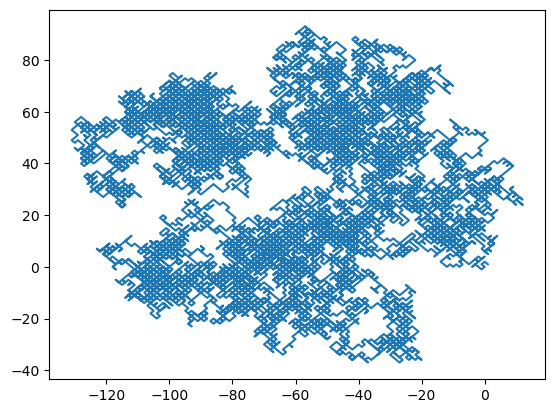

In [19]:
# Plot 2-D Random Walk
W = rw_d(20000, 2)
plt.plot(W[:,0], W[:,1])

## Problem 2. Reading MIMIC-IV datafile
In this exercise, we explore various tools for ingesting the [MIMIC-IV](https://mimic.mit.edu/docs/iv/) data introduced in BIOSTAT 203B, but we will do it in Python this time.

Let's display the contents of MIMIC `hosp` and `icu` data folders: (if a cell starts with a `!`, the command is run in the shell.)

### Directions To Setup Mimic

- Create a system link (`ln -s`) between Mimic and the current working directory of this notebook. Using a system link is storage efficient and allows for more readable relative paths to be used to reference the mimic data.

- Use the tags `-goh` to show permissions, size, and filename.

In [20]:
# Hosp Files
!ls -goh ./mimic/hosp/

total 9.6G
-rwxr-xr-x 1  15M May 19 14:49 admissions.csv.gz
-rwxr-xr-x 1  21M May 16 10:28 admissions.parquet
-rwxr-xr-x 1 418K May 19 14:49 d_hcpcs.csv.gz
-rwxr-xr-x 1 724K May  7 16:54 d_hcpcs.parquet
-rwxr-xr-x 1  24M May 19 14:49 diagnoses_icd.csv.gz
-rwxr-xr-x 1  21M May 16 10:28 diagnoses_icd.parquet
-rwxr-xr-x 1 840K May 19 14:49 d_icd_diagnoses.csv.gz
-rwxr-xr-x 1 1.7M May  7 16:55 d_icd_diagnoses.parquet
-rwxr-xr-x 1 565K May 19 14:49 d_icd_procedures.csv.gz
-rwxr-xr-x 1 1.3M May  7 16:55 d_icd_procedures.parquet
-rwxr-xr-x 1  13K May 19 14:49 d_labitems.csv.gz
-rwxr-xr-x 1  21K May  7 16:55 d_labitems.parquet
-rwxr-xr-x 1 7.1M May 19 14:49 drgcodes.csv.gz
-rwxr-xr-x 1 6.8M May 16 10:28 drgcodes.parquet
-rwxr-xr-x 1 485M May 19 14:49 emar.csv.gz
-rwxr-xr-x 1 450M May 19 14:49 emar_detail.csv.gz
-rwxr-xr-x 1 855M May  7 16:55 emar_detail.parquet
-rwxr-xr-x 1 754M May 16 14:38 emar.parquet
-rwxr-xr-x 1 1.7M May 19 14:49 hcpcsevents.csv.gz
-rwxr-xr-x 1 2.4M May  7 16:55 hcpcseven

In [21]:
# ICU Files
!ls -goh ./mimic/icu/

total 5.4G
-rwxr-xr-x 1  36K May 19 14:49 caregiver.csv.gz
-rwxr-xr-x 1  68K May  7 16:57 caregiver.parquet
-rwxr-xr-x 1 2.3G May 19 14:49 chartevents.csv.gz
-rwxr-xr-x 1 1.4G May 16 14:38 chartevents.parquet
-rwxr-xr-x 1  44M May 19 14:49 datetimeevents.csv.gz
-rwxr-xr-x 1  57M May  7 16:57 datetimeevents.parquet
-rwxr-xr-x 1  57K May 19 14:49 d_items.csv.gz
-rwxr-xr-x 1 114K May  7 16:58 d_items.parquet
-rwxr-xr-x 1 2.5M May 19 14:49 icustays.csv.gz
-rwxr-xr-x 1 3.8M May  7 16:59 icustays.parquet
-rwxr-xr-x 1 241M May 19 14:49 ingredientevents.csv.gz
-rwxr-xr-x 1 383M May 16 14:38 ingredientevents.parquet
-rwxr-xr-x 1 310M May 19 14:49 inputevents.csv.gz
-rwxr-xr-x 1 520M May 16 14:38 inputevents.parquet
-rwxr-xr-x 1  37M May 19 14:49 outputevents.csv.gz
-rwxr-xr-x 1  65M May 16 10:28 outputevents.parquet
-rwxr-xr-x 1  20M May 19 14:49 procedureevents.csv.gz
-rwxr-xr-x 1  34M May 16 10:28 procedureevents.parquet


### (A). Speed, memory, and data types

Standard way to read a CSV file would be using the `read_csv` function of the `pandas` package. Let us check the speed of reading a moderate-sized compressed csv file, `admissions.csv.gz`. How much memory does the resulting data frame use?

_Note:_ If you start a cell with `%%time`, the runtime will be measured. 

In [22]:
# this function is not required as part of the homework. The purpose of
# This function is to calculate the percent differences of data ingestion 
# methods.
def percent_diff(i_time=None, f_time=None, i_mem=None, f_mem=None):
  """
  Print Pandas and Polars Comparison Metrics
  ---
  Optional Args:
    i_time: A positive float. The runtime of a initial cell in s.
    f_time: A positive float. The runtime of a final cell in s.
    i_mem: A positive float. Initial dataframe object memory usage in GB.
    f_mem: A positive float. Final dataframe object memory usage in GB.
  Return:
    None
  """
  if (i_time is not None) and (f_time is not None): # Check if empty
    time_diff = round((f_time - i_time) / i_time * 100) # percent diff.
    if time_diff > 0: # if percent diff. is greater than 0 output text
      print(f"final runtime was {abs(time_diff)}% slower than initial.")
    elif time_diff < 0: # if percent diff. is less than 0 output text
      print(f"final runtime was {abs(time_diff)}% faster than initial.")
    elif time_diff == 0: # if percent diff. is equal to 0 output text
      print(f"final runtime was the same as initial.")
    else:
      raise TypeError
  else:
    pass
  if (i_mem is not None) and (f_mem is not None): # Check if empty
    mem_diff = round((f_mem - i_mem) / i_mem * 100) # percent diff
    if mem_diff > 0: # if percent diff. is greater than 0 output text
      print(f"final df memory usage was {abs(mem_diff)}% more than initial.")
    elif mem_diff < 0: # if percent diff. is less than 0 output text
      print(f"final df memory usage was {abs(mem_diff)}% less than initial.")
    elif mem_diff == 0: # if percent diff. is equal to 0 output text
      print(f"final df memory usage was the same as initial.")
    else:
      raise TypeError
  else:
    pass

### Answer 2A

#### Preface

It is more beneficial to compare the time and memory consumption of pandas to another method to better understand strengths and weaknesses of data ingestion methods therefore for each problem pandas will be compared to either polars or DuckDB. Runtime is a good metric to measure the performance of these libraries however, it is not consistent and will vary across systems and even within the same system depending on resource availability. Therefore the relative performance is a better metric than the absolute performance of these python libraries.

EDIT: The changes to the homework implimented on 5/6 disrupted the order of my test. Therefore, please don't markdown if the numbers changed significantly because the homework was significantly changed after I completed the assignment. Please don't change the homework after you disperse it. It is disruptive.

#### Pandas

The runtime to ingest `admissions.csv.gz` using pandas was 884 ms and the resulting data frame memory usage was 0.368 GB.

#### Polars

The runtime to ingest `admissions.csv.gz` using pandas was 214 ms and the resulting data frame memory usage was 0.362 GB.

#### Summary

Polars consumed less resources than pandas. The Polars runtime was __42% faster__ and the Polars data frame object memory usage was __2% less__ than Pandas. 

#### Description
Pandas was used to read in the admissions.csv.gz file from a symbolic link of the mimic data set located in the working directory.

In [23]:
%%time
## Pandas
# Read admissions using Pandas
df_pd_adm = pd.read_csv("./mimic/hosp/admissions.csv.gz")

CPU times: user 703 ms, sys: 76.7 ms, total: 780 ms
Wall time: 1.17 s


In [24]:
# Print the memory usage of the pandas object
print(round(sys.getsizeof(df_pd_adm)/10**9, 3), "GB")

0.368 GB


#### Description
Polars was used to read in the admissions.csv.gz file from a symbolic link of the mimic data set located in the working directory. Results are documented in the answer above. To make the memory usage consistent, the polars data frame was converted to a pandas data frame.

In [25]:
%%time
## Polars
# Read admissions using Polars then convert the Polars DataFrame (pl.DataFrame)
# to a Pandas DataFrame (pd.DataFrame).
df_pl_adm = pl.read_csv("./mimic/hosp/admissions.csv.gz").to_pandas()

CPU times: user 580 ms, sys: 495 ms, total: 1.08 s
Wall time: 690 ms


In [26]:
# Print the memory usage of the pandas object.
# The pl.DataFrame was converted to a pd.DataFrame
print(round(sys.getsizeof(df_pl_adm)/10**9, 3), "GB")

0.362 GB


In [106]:
# Initial: Pandas reading admissions.csv.gz
# Final: Polars reading admissions.csv.gz
percent_diff(i_time=1.17, i_mem=0.368, f_time=0.690, f_mem=0.362)

final runtime was 41% faster than initial.
final df memory usage was 2% less than initial.


### (B). User-supplied data types

Re-ingest `admissions.csv.gz` by indicating appropriate column data types in [`pd.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). Does the run time change? How much memory does the result dataframe use? (Hint: `dtype` and `parse_dates` arguments in `pd.read_csv`.)

### Answer 2B


#### Pandas (Categorical) 

Categorical variables were assigned as type `categorical`. Dates were assigned as date. The runtime to ingest `admissions.csv.gz` using pandas and declaring data types was 1.05 seconds and the resulting data frame memory usage was 0.029 GB. Compared to pandas reading without declaring data types (1A), the pandas runtime with declared data types was __10% Faster__ and the data frame memory usage was __92% less__.

#### Pandas (String)

Categorical variables were assigned as type `string`. Dates were assigned as date. The runtime to ingest `admissions.csv.gz` using pandas and declaring data types was 3.76 seconds and the resulting data frame memory usage was 0.277 GB. Compared to pandas reading without declaring data types (1A), the pandas runtime with declared data types was __6% Faster__ and the data frame memory usage was __24% less__.

#### Polars (Categorical)

Categorical variables were assigned as type `categorical`. Dates were assigned as date. The runtime to ingest `admissions.csv.gz` using polar and declaring data types was 0.207 seconds and the resulting data frame memory usage was 0.029 GB. Compared to pandas reading without declaring data types (1A), the polars runtime with declared data types was __81% faster__ and the data frame memory usage was __92% less__.


#### Summary
For pandas, declaring variables decreased the runtime and decreased the size of the resulting data frame. Additionally, for pandas the size of the resulting data frame was less when categorical variables were assigned the type, `categorical`, instead of `string`. Polars, was the fastest and had similar memory usage as pandas. This makes sense becasue polars is multi-threaded and built with rust.

#### Documentation

The admissions data set was read by pandas and while reading in the data, types were declared. declaring column has the potential to improve resource usage while upholding data, integrity. In addition, polars was used to also read in the data using a similar method of declaring column. for pandas two methods were tested. One method declared categorical variables as string type however that did not perform as well as declaring the categorical variables as categories instead of strings. To make the memory usage consistent, the polars data frame was converted to a pandas data frame.

In [28]:
%%time

## Pandas
# Assign data types while reading. For categorical variables assign the dtype as
# a category.
df_pd_cat_adm = pd.read_csv(
  "./mimic/hosp/admissions.csv.gz",
  # assign data types
  dtype={
    'subject_id': 'int64',
    'hadm_id': 'int64',
    'admission_type': 'category',
    'admit_provider_id': 'category',
    'admission_location': 'category',
    'discharge_location': 'category',
    'insurance': 'category',
    'language': 'category',
    'marital_status': 'category',
    'race': 'category',
    'hospital_expire_flag': 'category'
  },
  # assign date types
  parse_dates=[
    'admittime',
    'dischtime',
    'deathtime',
    'edregtime',
    'admittime',
    'edouttime',
    'deathtime',
  ]
)

CPU times: user 971 ms, sys: 92.4 ms, total: 1.06 s
Wall time: 1.05 s


In [29]:
# Object memory usage
print(round(sys.getsizeof(df_pd_cat_adm)/10**9,3), "GB")

0.029 GB


In [107]:
# Initial = Pandas without declared data types
# Final = Pandas with declared data types (categorical)
percent_diff(i_time=1.17, i_mem=0.368, f_time=1.05, f_mem=0.029)

final runtime was 10% faster than initial.
final df memory usage was 92% less than initial.


In [31]:
%%time

## Pandas
# Assign data types while reading. For categorical variables assign the dtype as
# a string.
df_pd_str_adm = (
  pd.read_csv(
    "./mimic/hosp/admissions.csv.gz",
    # assign data types
    dtype={
      'subject_id': 'int64',
      'hadm_id': 'int64',
      'admission_type': 'string',
      'admit_provider_id': 'string',
      'admission_location': 'string',
      'discharge_location': 'string',
      'insurance': 'string',
      'language': 'string',
      'marital_status': 'string',
      'race': 'string',
      'hospital_expire_flag': 'string'
    },
    # assign date types
    parse_dates=[
      'admittime',
      'dischtime',
      'deathtime',
      'edregtime',
      'admittime',
      'edouttime',
      'deathtime',])
)

CPU times: user 1.03 s, sys: 68.1 ms, total: 1.1 s
Wall time: 1.1 s


In [32]:
# Object memory Usage
print(round(sys.getsizeof(df_pd_str_adm)/10**9, 3), "GB")

0.278 GB


In [108]:
# Initial = Pandas without declared data types
# Final = Pandas with declared data types (string)
percent_diff(i_time=1.17, i_mem=0.368, f_time=1.1, f_mem=0.278)

final runtime was 6% faster than initial.
final df memory usage was 24% less than initial.


In [34]:
%%time

## Polars
# Assign data types while reading. For categorical variables assign the dtype as
# a category.
df_pl_cat_adm = (
  pl.read_csv(
    "./mimic/hosp/admissions.csv.gz", # read file
    # assign data types
    dtypes={ 
      'subject_id': pl.Int64,
      'hadm_id': pl.Int64,
      'admission_type': pl.Categorical,
      'admit_provider_id': pl.Categorical,
      'admission_location': pl.Categorical,
      'discharge_location': pl.Categorical,
      'insurance': pl.Categorical,
      'language': pl.Categorical,
      'marital_status': pl.Categorical,
      'race': pl.Categorical,
      'hospital_expire_flag': pl.Categorical}, 
    try_parse_dates=True) # convert columns to date.
  .to_pandas() # convert to pd.dataframe
)

CPU times: user 573 ms, sys: 91.5 ms, total: 665 ms
Wall time: 228 ms


In [109]:
# Polars Object memory usage
print(round(sys.getsizeof(df_pl_cat_adm)/10**9,3), "GB")

0.029 GB


In [111]:
# Initial = Polars without declared data types(initial) 
# Final = Polars with declared data types
percent_diff(i_time=1.17, i_mem=0.368, f_time=0.220, f_mem=0.029)

final runtime was 81% faster than initial.
final df memory usage was 92% less than initial.


## Problem 3. Ingest big data files


Let us focus on a bigger file, `labevents.csv.gz`, which is about 125x bigger than `admissions.csv.gz`.

##### Documentation
The below code is bash. The size of lab events is 1.8 GB below that code are the first 10 rows of lab events using bash.

In [37]:
# Size of labevents as a csv.gz
!ls -goh ./mimic/hosp/labevents.csv.gz

-rwxr-xr-x 1 1.9G May 19 13:24 ./mimic/hosp/labevents.csv.gz


Display the first 10 lines of this file.

In [38]:
# First 10 results of labevents
!zcat < ./mimic/hosp/labevents.csv.gz | head -10

labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
1,10000032,,45421181,51237,P28Z0X,2180-03-23 11:51:00,2180-03-23 15:15:00,1.4,1.4,,0.9,1.1,abnormal,ROUTINE,
2,10000032,,45421181,51274,P28Z0X,2180-03-23 11:51:00,2180-03-23 15:15:00,___,15.1,sec,9.4,12.5,abnormal,ROUTINE,VERIFIED.
3,10000032,,52958335,50853,P28Z0X,2180-03-23 11:51:00,2180-03-25 11:06:00,___,15,ng/mL,30,60,abnormal,ROUTINE,NEW ASSAY IN USE ___: DETECTS D2 AND D3 25-OH ACCURATELY.
4,10000032,,52958335,50861,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,102,102,IU/L,0,40,abnormal,ROUTINE,
5,10000032,,52958335,50862,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,3.3,3.3,g/dL,3.5,5.2,abnormal,ROUTINE,
6,10000032,,52958335,50863,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,109,109,IU/L,35,105,abnormal,ROUTINE,
7,10000032,,52958335,50864,P28Z0X,2180-03-23 11:51:00,2180-03-23 16:40:00,___,8,ng/mL,0,8.7,,ROUTI

### (A). Ingest `labevents.csv.gz` by `pd.read_csv`

Try to ingest `labevents.csv.gz` using `pd.read_csv`. What happens? If it takes more than 5 minutes on your computer, then abort the program and report your findings. 

### Answer 3A

#### Pandas

Pandas was able to read `labevents.csv.gz` within 5 minutes. The runtime to read the file was 2 minutes and the resulting data frame memory usage was 61 GB.

final runtime was 32% faster than initial.
final df memory usage was 3% more than initial.
#### Polars

Polars was able to read `labevents.csv.gz` within 5 min. The runtime to read the file was 1 minute and 22 seconds.

#### Summary

The runtime to read in the compressed csv, labevents, using Polars was 32% faster than Pandas, but the resulting memory usage of the dataframe was 3% more which is an acceptable tradeoff for the time savings.

#### Description
The compressed CSV labevents was read by pandas and polars. To make the memory usage consistent, the polars data frame was converted to a pandas data frame.

In [39]:
%%time
#Pandas read labevents.csv.gz
df_pd_lab = pd.read_csv("./mimic/hosp/labevents.csv.gz")

CPU times: user 1min 40s, sys: 21.1 s, total: 2min 1s
Wall time: 2min 1s


In [40]:
print(round(sys.getsizeof(df_pd_lab)/10**9,3), "GB")

61.002 GB


In [41]:
%%time
#Polars read labevents.csv.gz
df_pl_lab = pl.read_csv("./mimic/hosp/labevents.csv.gz").to_pandas()

CPU times: user 1min 48s, sys: 2min, total: 3min 48s
Wall time: 1min 22s


In [42]:
print(round(sys.getsizeof(df_pl_lab)/10**9,3), "GB")

62.998 GB


In [112]:
# Initial: Pandas reading labevents
# Final: Polars reading labevents
percent_diff(
  i_time=(2 * 60 + 1),
  i_mem=61.002, 
  f_time=(1 * 60 + 22), 
  f_mem=62.998
)

final runtime was 32% faster than initial.
final df memory usage was 3% more than initial.


### (B). Ingest selected columns of `labevents.csv.gz` by `pd.read_csv`

Try to ingest only columns `subject_id`, `itemid`, `charttime`, and `valuenum` in `labevents.csv.gz` using `pd.read_csv`.  Does this solve the ingestion issue? (Hint: `usecols` argument in `pd.read_csv`.)

### Answer 3B

#### Pandas

The runtime to read selected columns of the file was 1 minute and 7 seconds and the resulting data frame memory usage was 11.817 GB. The runtime for reading selected columns in pandas was __45% faster__ and the resulting data frame memory usage was __81% smaller__ when compared the pandas reading all columns.

#### Polars

The runtime to read selected columns of the file was 44.8 seconds and the resulting data frame memory usage was 11.817 GB. The runtime for reading selected columns in polars was __74% faster__ and the resulting data frame memory usage was __81% smaller__ when compared the pandas reading all columns.

#### Summary

Again, Polars was the fastest method for reading in an selecting columns.

Description: While reading the compressed CSV file labevents using pandas, the columns were selected. This was replicated for polars as well. To make the memory usage consistent, the polars data frame was converted to a pandas data frame.

In [113]:
%%time
# Pandas Read select labevent columns
df_pd_lab = pd.read_csv("./mimic/hosp/labevents.csv.gz", usecols = lab_col)

CPU times: user 1min 7s, sys: 2.13 s, total: 1min 9s
Wall time: 1min 14s


In [114]:
print(round(sys.getsizeof(df_pd_lab)/10**9,3), "GB")

11.817 GB


In [115]:
# Initial: Pandas reading all columns
# Final: Pandas reading selected columns
percent_diff(
  i_time= (2 * 60 + 1),
  i_mem= 61.002,
  f_time= (1 * 60 + 7),
  f_mem= 11.817
)

final runtime was 45% faster than initial.
final df memory usage was 81% less than initial.


In [116]:
%%time
# Polars Read select labevent columns
df_pl_lab = (
  pl.read_csv("./mimic/hosp/labevents.csv.gz", # read file
    columns = lab_col) # Select columns
    .to_pandas() # Convert pl.dataframe to pd.dataframe
)

CPU times: user 39.8 s, sys: 19.8 s, total: 59.6 s
Wall time: 30.9 s


In [117]:
print(round(sys.getsizeof(df_pl_lab)/10**9,3), "GB")

11.817 GB


In [118]:
# Initial: Pandas reading all columns
# Final: Polars reading specific columns
percent_diff(
  i_time= (2 * 60 + 1),
  i_mem= 61.002,
  f_time= (30.9),
  f_mem= 11.817
)

final runtime was 74% faster than initial.
final df memory usage was 81% less than initial.


### (C). Ingest subset of `labevents.csv.gz`

Back in BIOSTAT 203B, our first strategy to handle this big data file was to make a subset of the `labevents` data.  Read the [MIMIC documentation](https://mimic.mit.edu/docs/iv/modules/hosp/labevents/) for the content in data file `labevents.csv.gz`.

As before, we will only be interested in the following lab items: creatinine (50912), potassium (50971), sodium (50983), chloride (50902), bicarbonate (50882), hematocrit (51221), white blood cell count (51301), and glucose (50931) and the following columns: `subject_id`, `itemid`, `charttime`, `valuenum`. 

Rerun the Bash command to extract these columns and rows from `labevents.csv.gz` and save the result to a new file `labevents_filtered.csv.gz` in the current working directory (Q2.3 of HW2). How long does it take?(_Updated 5/6: You may reuse the file you created last quarter and report the elapsed time from the last quarter for this part._)

Display the first 10 lines of the new file `labevents_filtered.csv.gz`. How many lines are in this new file? How long does it take `pd.read_csv()` to ingest `labevents_filtered.csv.gz`?


### Answer 3C

The runtime to select columns and filter `labevents` using Bash was 1 minute and 36 seconds and the runtime to ingest `labevents_filtered` was 10 seconds. The number of rows in the resulting dataset was 24,855,909.

Description: the below bash code reads in the compressed CSV labevents using zcat, then is filtered by Rows that equal the necessary item IDs and finally select the columns. This is then saved to another compressed CSV called lab events filtered. After processing the data using bash, pandas was used to read the file that was created in bash. The first 10 rows of the file was displayed using pandas `head` function.

In [65]:
%%bash
# Read labevents, select columns, and filter rows by itemid
time(zcat < ./mimic/hosp/labevents.csv.gz | \
  awk -F, \
  'BEGIN {OFS = ","} {if (NR == 1 || $5 == 50912 || $5 == 50971 ||
    $5 == 50983 || $5 == 50902 || $5 == 50882 || $5 == 51221 || 
    $5 == 51301 || $5 == 50931) {print $2, $5, $7, $10}}' | \
  gzip > labevents_filtered.csv.gz)
echo "complete"


real	1m36.863s
user	2m39.064s
sys	0m6.787s


complete


In [66]:
%%time
# Pandas read labevents_filtered.csv.gz
df_pd_lab_filter = pd.read_csv("./labevents_filtered.csv.gz")

CPU times: user 6.33 s, sys: 845 ms, total: 7.17 s
Wall time: 10.2 s


In [67]:
df_pd_lab_filter.head(10)

,subject_id,itemid,charttime,valuenum
0,10000032,50882,2180-03-23 11:51:00,27.0
1,10000032,50902,2180-03-23 11:51:00,101.0
2,10000032,50912,2180-03-23 11:51:00,0.4
3,10000032,50971,2180-03-23 11:51:00,3.7
4,10000032,50983,2180-03-23 11:51:00,136.0
5,10000032,50931,2180-03-23 11:51:00,95.0
6,10000032,51221,2180-03-23 11:51:00,45.4
7,10000032,51301,2180-03-23 11:51:00,3.0
8,10000032,51221,2180-05-06 22:25:00,42.6
9,10000032,51301,2180-05-06 22:25:00,5.0


In [68]:
df_pd_lab_filter.shape

(24855909, 4)

In [69]:
print(round(sys.getsizeof(df_pd_lab_filter)/10**9,3), "GB")

2.486 GB


### (D). Review

Write several sentences on what Apache Arrow, the Parquet format, and DuckDB are. Imagine you want to explain it to a layman in an elevator, as you did before. (It's OK to copy-paste the sentences from your previous submission.)

Also, now is the good time to review [basic SQL commands](https://ucla-biostat-203b.github.io/2024winter/slides/12-dbplyr/dbintro.html) covered in BIOSTAT 203B.

### Answer 3D

#### Apache Arrow

Apache Arrow is fast. By organizing data in columnar format and reducing redundant operations, it is able to accomplish similar tasks as pandas in a fraction of the time ([Apache Arrow](https://arrow.apache.org/overview/)).

#### Parquet Format

Parquet is an efficient storage format. It stores data in a columnar format efficiently by creating encoding dictionaries and bit-packing, allowing it be faster and smaller than csv files ([Apache Parquet](https://parquet.apache.org/docs/file-format/)).

#### DuckDB

DuckDB is a fast and portable database management system. DuckDB can connect to database servers or be server-less, performing SQL operations on large files and tables while being memory and time efficient. It also has support across a wide range of languages.([DuckDB](https://duckdb.org/why_duckdb.html#:~:text=DuckDB%20offers%20a%20flexible%20extension,protocols%20are%20implemented%20as%20extensions.)).


### (E). Ingest `labevents.csv.gz` by Apache Arrow (modified 5/6)

Our second strategy again is to use [Apache Arrow](https://arrow.apache.org/) for larger-than-memory data analytics. We will use the package `pyarrow`. Unlike in R, this package works with the `csv.gz` format. We don't need to keep the decompressed data on disk. We could just use `dplyr` verbs in R, but here, we need a different set of commands. The core idea behind the commands are still similar, though. There is one notable difference in approach: 

- R's `arrow` package allowed lazy evaluation but required `csv` file to be decompressed beforehand. 
- On the other hand, `pyarrow` allows `csv.gz` format, but lazy evaluation is not available. For larger-than-memory data, streaming approach can be used.

Follow these steps to ingest the data:
- Use [`pyarrow.csv.read_csv`](https://arrow.apache.org/docs/python/generated/pyarrow.csv.read_csv.html) to read in `labevents.csv.gz`. It creates an object of type [`pyarrow.Table`](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html). _If this does not work on your computer, state that fact. It's OK to not complete this part in that case. However, you still need the `filter_table()` function for the next part. It's still recommend to _

- Define a function `filter_table()` that takes in a `pyarrow.Table` as an argument, and returns `pyarrow.Table` doing the following:
    - Select columns using the [`.select()`](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.select) method. 
    - Filter the rows based on the column `itemid` using the [`.filter()`](https://arrow.apache.org/docs/python/generated/pyarrow.Table.html#pyarrow.Table.filter) method. You should use [`Expression`](https://arrow.apache.org/docs/python/generated/pyarrow.dataset.Expression) for improved performance. In particular, use the `isin()` method for constructing it.
    
- Finally, let's obtain the result in `pandas` `DataFrame` using the method `.to_pandas()`. 

How long does the ingest+select+filter process take? Display the number of rows and the first 10 rows of the result dataframe, and make sure they match those of (C).


### Answer 3E

#### Apache Arrow

The runtime to read "labevents.csv.gz", select columns, and filter rows was 1 minute 16 seconds and the resulting data frame memory usage was 0.606 GB. 

Description: homework three was changed and now requires a function to be used to filter a pyarrow table. Therefore, filter_table was used to select columns and filter rose by items in the table and return a filter table. Inside the function are the columns and item IDs. We wish to filter the table. The arrow functions select and filter were used to filter the data set. In order to use the filter function, additional arrow functions were needed such as `is_in` and `field` to specify which column to filter by and format the input in a compatible way.

In [70]:
def filter_table(arrow_tbl):
  """
  Select columns in columns_filter and filter rows by items in items_filter from
  a pyarrows table and return a filtered pyarrows table.
  Args:
    arrow_tbl: A pa.Table of labevents.csv.gz
  Return:
    pa_tbl_ftr: A filtered pa.Table of labevents.csv.gz
  """
  lab_col = ['subject_id', 'itemid', 'charttime', 'valuenum']
  lab_itemid = [50912, 50971, 50983, 50902, 50882, 51221, 51301, 50931]
  pa_tbl_ftr = (
    arrow_tbl # pa.dataframe
    .select(lab_col) # select columns
    .filter(pc.is_in(pc.field("itemid"), pa.array(lab_itemid))) # filter by itemid
  )
  return pa_tbl_ftr

In [71]:
%%time
df_pa_lab_ftr = csv.read_csv(pth_hsp + "labevents.csv.gz") # read file
df_pa_lab_ftr = filter_table(df_pa_lab_ftr).to_pandas()


CPU times: user 1min 14s, sys: 18 s, total: 1min 32s
Wall time: 20 s


In [72]:
print(round(sys.getsizeof(df_pa_lab_ftr)/10**9,3), "GB")

0.795 GB


In [73]:
df_pa_lab_ftr.shape

(24855909, 4)

In [74]:
df_pa_lab_ftr.head(10)

,subject_id,itemid,charttime,valuenum
0,10000032,50882,2180-03-23 11:51:00,27.0
1,10000032,50902,2180-03-23 11:51:00,101.0
2,10000032,50912,2180-03-23 11:51:00,0.4
3,10000032,50971,2180-03-23 11:51:00,3.7
4,10000032,50983,2180-03-23 11:51:00,136.0
5,10000032,50931,2180-03-23 11:51:00,95.0
6,10000032,51221,2180-03-23 11:51:00,45.4
7,10000032,51301,2180-03-23 11:51:00,3.0
8,10000032,51221,2180-05-06 22:25:00,42.6
9,10000032,51301,2180-05-06 22:25:00,5.0


### (F). Streaming data (added 5/6)

When working with the `csv.gz` file, the entire file will need to be decompressed in memory, which might not be feasible. You can stream data, and processing them in several chunks that fits into the memory.

If the function `filter_table()` is defined correctly, the following should successfully ingest the data. Discuss what this code is doing in markdown. Also, add sufficient comment to the code. 

### Answer 3F

#### Apache Arrow (Read, Select, Filter, then Convert to parquet)

The runtime to read, select, filter `labevents.csv.gz` in batches and write as a parquet was 80 seconds and the resulting parquet file was 101 MB.

Description: Below is an additional way to read in the compressed CSV of labevents. Similar to the base python function `with open`, arrow has a similar function called `open_csv`. Unlike the previous arrow method, the file is streamed into the python environment instead of all at once. This allows for the file to be batched. Batches consume less memory than reading in the whole data set at once; Therefore, for systems with less resources, those systems are able to open the file. This is done by reading in each batch, then filtering that batch and appending it to a python object. The final object is a arrow table. The arrow table is converted to a pandas data frame.

In [75]:
%%time

# Path to labevents
in_path = './mimic/hosp/labevents.csv.gz'

# initialize filtered object
filtered = None
# open csv as reader
with csv.open_csv(in_path) as reader:
  # for each partition in the reader.
  for next_chunk in reader:
    # if the partition is empty stop loop
    if next_chunk is None:
      break
    # Convert chunk/partition into a table
    next_table = pa.Table.from_batches([next_chunk])
    # Filter that chunk/partition by filter_table
    next_subset = filter_table(next_table)
    # For the first chunk, have the filtered chunk assigned to filtered.
    if filtered is None:
      filtered = next_subset
    # Otherwise append that chuck to the bottom of the filtered
    else:
      filtered = pa.concat_tables([filtered, next_subset])

filtered_df = filtered.to_pandas()

CPU times: user 1min 16s, sys: 8.31 s, total: 1min 25s
Wall time: 59.9 s


In [76]:
print(round(sys.getsizeof(filtered_df)/10**9,3), "GB")

0.795 GB


In [77]:
filtered_df.head(10)

,subject_id,itemid,charttime,valuenum
0,10000032,50882,2180-03-23 11:51:00,27.0
1,10000032,50902,2180-03-23 11:51:00,101.0
2,10000032,50912,2180-03-23 11:51:00,0.4
3,10000032,50971,2180-03-23 11:51:00,3.7
4,10000032,50983,2180-03-23 11:51:00,136.0
5,10000032,50931,2180-03-23 11:51:00,95.0
6,10000032,51221,2180-03-23 11:51:00,45.4
7,10000032,51301,2180-03-23 11:51:00,3.0
8,10000032,51221,2180-05-06 22:25:00,42.6
9,10000032,51301,2180-05-06 22:25:00,5.0


### (G). Convert `labevents.csv.gz` to Parquet format and ingest/select/filter

Re-write the csv.gz file `labevents.csv.gz` in the binary Parquet format using the code below. Add comments to the code. How large is the Parquet file(s)?

### Answer 3G

The resulting parquet file from the below code was 2.0 gb which is 5% more than the csv.gz counterpart. This is still a good result because the parquet file is not compressed and is faster to load than csv.gz because it does not have to be decompressed when using some libraries.

To filter the parquet using pyarrow, the runtime was 5.32 seconds and the memory usage was 0.795 GB. Using pyarrow to filter a parquet file was 91% faster than filtering on the compressed csv file.

#### Documentation

PyArrow was used to stream chunks from the compressed csv file, labevents, to a parquet file using `open_csv` to stream in the data and `ParquetWriter` to steam the chucks into a parquet file format. Similar to the base python function with open, arrow has a similar function called `open_csv`. The file is streamed into the python environment instead of all at once. This allows for the file to be batched. Batches consume less memory than reading in the whole data set at once; Therefore, for systems with less resources, those systems are able to open the file. To stream the batches into a parquet file format, the object, `writer`, is initialized to using `ParquetWriter` which is a class that allows for iterative building of a parquet file. Each batch is added to this oject class and once the file is created, the files is closed.

In [90]:
%%time
# Set the path to the symbolic link directory and labevents
in_path = './mimic/hosp/labevents.csv.gz'
# Set the save parquet path
out_path = './labevents.parquet'

# Initialize the object.
writer = None
# Stream the compressed csv to the python object reader
with csv.open_csv(in_path) as reader:
    # Loop through each chuck from the streamed object, reader.
    for next_chunk in reader:
        # stop if the chunck is the empty which is true when at end of stream
        if next_chunk is None:
            break
        # If writer is empty,
        # initialize object, writer, for incrementally building a Parquet file.
        if writer is None:
            writer = pq.ParquetWriter(out_path, next_chunk.schema)
        # For each chunk, add the chunk to next_table
        next_table = pa.Table.from_batches([next_chunk])
        # For each chunk, write write table as parquet using the
        # object, writer which was initialized when it was first empty.
        writer.write_table(next_table)
writer.close() # Close the streaming to prevent errors and improve security.

CPU times: user 1min 43s, sys: 5.81 s, total: 1min 49s
Wall time: 1min 29s


In [91]:
!ls -goh ./labevents.parquet

-rw-r--r-- 1 2.0G May 19 16:45 ./labevents.parquet


In [92]:
!ls -goh ./mimic/hosp/labevents.csv.gz

-rwxr-xr-x 1 1.9G May 19 13:24 ./mimic/hosp/labevents.csv.gz


In [93]:
# Initial is labevents.csv.gz
# Final is labevents.parquet
percent_diff(
    i_mem = 1.9,
    f_mem = 2.0
)

final df memory usage was 5% more than initial.


In [124]:
%%time
df_pa_lab_ftr = (
  pq.read_table('./labevents.parquet') # read labevents.parquet
  .select(lab_col) # select columns
  .filter(pc.is_in(pc.field("itemid"), pa.array(lab_itemid))) # Filter by itemid
  .sort_by([("subject_id", "ascending"),("charttime", "ascending")])
  .to_pandas() # Convert to pd.dataframe
)

CPU times: user 32.1 s, sys: 13.5 s, total: 45.6 s
Wall time: 5.32 s


In [125]:
print(round(sys.getsizeof(df_pa_lab_ftr)/10**9,3), "GB")

0.795 GB


In [126]:
df_pa_lab_ftr.head(10)

,subject_id,itemid,charttime,valuenum
0,10000032,50882,2180-03-23 11:51:00,27.0
1,10000032,50902,2180-03-23 11:51:00,101.0
2,10000032,50912,2180-03-23 11:51:00,0.4
3,10000032,50971,2180-03-23 11:51:00,3.7
4,10000032,50983,2180-03-23 11:51:00,136.0
5,10000032,50931,2180-03-23 11:51:00,95.0
6,10000032,51221,2180-03-23 11:51:00,45.4
7,10000032,51301,2180-03-23 11:51:00,3.0
8,10000032,51221,2180-05-06 22:25:00,42.6
9,10000032,51301,2180-05-06 22:25:00,5.0


In [127]:
percent_diff(
    i_time= 59.9,
    i_mem= 0.795,
    f_time= 5.32,
    f_mem= 0.795
)

final runtime was 91% faster than initial.
final df memory usage was the same as initial.


### (H). DuckDB

Let's use `duckdb` package in Python to use the DuckDB interface. In Python, DuckDB can interact smoothly with `pandas` and `pyarrow`. I recommend reading: 

- https://duckdb.org/2021/05/14/sql-on-pandas.html
- https://duckdb.org/docs/guides/python/sql_on_arrow.html

In Python, you will mostly use SQL commands to work with DuckDB. Check out the [data ingestion API](https://duckdb.org/docs/api/python/data_ingestion).


Ingest the Parquet file, select columns, and filter rows as in (F). How long does the ingest+select+filter process take? Please make sure to call `.df()` method to have the final result as a `pandas` `DataFrame`. Display the number of rows and the first 10 rows of the result dataframe and make sure they match those in (C). 

__This should be significantly faster than the results before (but not including) Part (F).__ 
_Hint_: It could be a single SQL command.


### Answer 3H

#### PyArrow

The runtime to read, select, and filter the parquet was 5.32 seconds and the resulting data frame memory usage was 0.795 GB.

#### DuckDB

The runtime to read, select, and filter the parquet was 7.89 seconds and the resulting data frame memory usage was 0.795 GB.

#### Polars

The runtime to read, select, and filter the parquet was 1.95 seconds and the resulting data frame memory usage was 0.795 GB.

final runtime was 75% faster than initial.
final df memory usage was the same as initial.

#### Summary

The runtime to read, select, and filter the parquet in polars was __75% faster__ than DuckDB and __63% faster__ than PyArrow, but resulted in the same memory usage as DuckDB.

#### Documentation

DuckDB was used to read, select columns and filter by item ID. A database was created in memory. The programming language SQL was used to select columns, read in the parquet, and filter by itemid. Using this method however resulted in a dataset with a different order than the bash method. to match the bash method, an order by statement was added to the SQL query. After adding the orderby, the output matched the bash command.
 
PyArrow was used to read, select columns, and filter by item ID. Unlike the previous PyArrow functions, `read_csv`, was used which reads in all of the file at once instead of batches. It is less memory efficient but is faster than reading in batches. In order to use the filter function, additional arrow functions were needed such as `is_in` and `field` to specify which column to filter by and format the input in a compatible way.

Polars was used to read, select columns, and filter by item ID. Unlike the other methods, Polars didn't read in the data at all and only created a link because the parquet file was lazy loaded. before reading in the data, queries were supplied to polars and polars organized the queries in the most efficient order and performed them and read in the parquet file when it was collected.

In [96]:
%%time
# open server-less database and close when done
with duckdb.connect(database=':memory:') as con:
  # SQL query
  df_db_lab_ftr = con.execute(
    """
    SELECT subject_id, itemid, charttime, valuenum
    FROM './labevents.parquet' 
    WHERE itemid IN (50912, 50971, 50983, 50902, 50882, 51221, 51301, 50931)
    ORDER BY subject_id, charttime ASC
    """
  ).df() # Output as pandas data frame

CPU times: user 13.3 s, sys: 9.36 s, total: 22.7 s
Wall time: 7.89 s


In [97]:
print(round(sys.getsizeof(df_db_lab_ftr)/10**9,3), "GB")

0.795 GB


In [98]:
df_db_lab_ftr.head(10)

,subject_id,itemid,charttime,valuenum
0,10000032,50882,2180-03-23 11:51:00,27.0
1,10000032,50902,2180-03-23 11:51:00,101.0
2,10000032,50912,2180-03-23 11:51:00,0.4
3,10000032,50971,2180-03-23 11:51:00,3.7
4,10000032,50983,2180-03-23 11:51:00,136.0
5,10000032,50931,2180-03-23 11:51:00,95.0
6,10000032,51221,2180-03-23 11:51:00,45.4
7,10000032,51301,2180-03-23 11:51:00,3.0
8,10000032,51221,2180-05-06 22:25:00,42.6
9,10000032,51301,2180-05-06 22:25:00,5.0


In [120]:
%%time
df_pl_lab_ftr = (
  pl.scan_parquet('./labevents.parquet') # lazy read
  .select(lab_col) # select columns
  .filter(pl.col('itemid').is_in(lab_itemid)) # filter rows
  .sort(['subject_id','charttime'])
  .collect() # collect pl.lazyframe to pl.dataframe
  .to_pandas() # convert to pd.dataframe
)

CPU times: user 7.16 s, sys: 2.08 s, total: 9.24 s
Wall time: 1.95 s


In [121]:
print(round(sys.getsizeof(df_pl_lab_ftr)/10**9,3), "GB")

0.795 GB


In [123]:
df_pl_lab_ftr.head(10)

,subject_id,itemid,charttime,valuenum
0,10000032,50882,2180-03-23 11:51:00,27.0
1,10000032,50902,2180-03-23 11:51:00,101.0
2,10000032,50912,2180-03-23 11:51:00,0.4
3,10000032,50971,2180-03-23 11:51:00,3.7
4,10000032,50983,2180-03-23 11:51:00,136.0
5,10000032,50931,2180-03-23 11:51:00,95.0
6,10000032,51221,2180-03-23 11:51:00,45.4
7,10000032,51301,2180-03-23 11:51:00,3.0
8,10000032,51221,2180-05-06 22:25:00,42.6
9,10000032,51301,2180-05-06 22:25:00,5.0


In [122]:
# Initial: DuckDB read, select, and filter
# Final: Polars read, select, and filter
percent_diff(
  i_time = 7.89,
  i_mem = 0.795,
  f_time = 1.95,
  f_mem = 0.795
)

final runtime was 75% faster than initial.
final df memory usage was the same as initial.


In [128]:
# Initial: Pyarrow read, select, and filter
# Final: Polars read, select, and filter
percent_diff(
  i_time = 5.32,
  i_mem = 0.795,
  f_time = 1.95,
  f_mem = 0.795
)

final runtime was 63% faster than initial.
final df memory usage was the same as initial.


### (I). Comparison (added 5/6)
Compare your results with those from Homework 2 of BIOSTAT 203B. 

The biggest comparison between Homework 2 from Biostat 203B and this assignment is between R and python and the packages and libraries that were used in each. For example, reading in the dataset, labevents, with tidyverse did not work, my system crashed and it took over 5 minutes. Similarly, when I tried to read in only select columns of labevents with tidyverse, it also crashed and it took over 5 minutes. Bash was needed to decompress the labevents file for pyarrow to work. Pyarrow was able to read in the decompressed csv. The total time to decompress and read in the data was 119 seconds, significantly more than the 74 seconds to read in the data with pyarrow. DuckDB in R also needed a decompressed csv. Therefore, it's faster to use python and pyarrow, duckdb, polars, and pandas than any of the packages used in R in the 203B HW2.

## Problem 4. Ingest and filter `chartevents.csv.gz`

[`chartevents.csv.gz`](https://mimic.mit.edu/docs/iv/modules/icu/chartevents/) contains all the charted data available for a patient. During their ICU stay, the primary repository of a patient’s information is their electronic chart. The `itemid` variable indicates a single measurement type in the database. The `value` variable is the value measured for `itemid`. The first 10 lines of `chartevents.csv.gz` are


#### Documentation

The bash commands below output the first 10 rows of chartevents and d_items.

In [100]:
!zcat < ./mimic/icu/chartevents.csv.gz | head -10

subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220179,82,82,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220180,59,59,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220181,63,63,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220045,94,94,bpm,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220179,85,85,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220180,55,55,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220181,62,62,mmHg,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220210,20,20,insp/min,0
10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220277,95,95,%,0

gzip: stdout: Broken pipe


[`d_items.csv.gz`](https://mimic.mit.edu/docs/iv/modules/icu/d_items/) is the dictionary for the `itemid` in `chartevents.csv.gz`.

In [101]:
!zcat < ./mimic/icu/d_items.csv.gz | head -10

itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
220001,Problem List,Problem List,chartevents,General,,Text,,
220003,ICU Admission date,ICU Admission date,datetimeevents,ADT,,Date and time,,
220045,Heart Rate,HR,chartevents,Routine Vital Signs,bpm,Numeric,,
220046,Heart rate Alarm - High,HR Alarm - High,chartevents,Alarms,bpm,Numeric,,
220047,Heart Rate Alarm - Low,HR Alarm - Low,chartevents,Alarms,bpm,Numeric,,
220048,Heart Rhythm,Heart Rhythm,chartevents,Routine Vital Signs,,Text,,
220050,Arterial Blood Pressure systolic,ABPs,chartevents,Routine Vital Signs,mmHg,Numeric,90,140
220051,Arterial Blood Pressure diastolic,ABPd,chartevents,Routine Vital Signs,mmHg,Numeric,60,90
220052,Arterial Blood Pressure mean,ABPm,chartevents,Routine Vital Signs,mmHg,Numeric,,

gzip: stdout: Broken pipe


Again, we are interested in the vitals for ICU patients: heart rate (220045), mean non-invasive blood pressure (220181), systolic non-invasive blood pressure (220179), body temperature in Fahrenheit (223761), and respiratory rate (220210). Retrieve a subset of `chartevents.csv.gz` only containing these items, using the favorite method you learnt in Problem 3. 

Document the steps and show your code. Display the number of rows and the first 10 rows of the result `DataFrame`.

### Answer 4

#### DuckDB

DuckDB was chosen over pandas, Apache Arrow, and polars becuase it was the fastest and most reliable at reading in a large, compressed csv. The runtime to read, select, and filter `chartevents.csv.gz` was 1min 31s and the resulting data frame was .

Polars was unable to read the compressed csv.

In [129]:
%%time
# open server-less database in memory and close when done.
with duckdb.connect(database=':memory:') as con:
    df_db_chrt_ftr = con.execute( # SQL query
      """
      SELECT *
      FROM './mimic/icu/chartevents.csv.gz' 
      WHERE itemid IN (220045, 220181, 220179, 223761, 220210)
      """
    ).df() # Output as pandas dataframe

CPU times: user 3min 32s, sys: 20.4 s, total: 3min 52s
Wall time: 1min 1s


In [130]:
df_db_chrt_ftr.shape

(22502319, 11)

In [131]:
print(round(sys.getsizeof(df_db_chrt_ftr)/10**9,3), "GB")

4.381 GB


In [132]:
df_db_chrt_ftr.head(10)

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
0,10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220179,82,82.0,mmHg,0
1,10000032,29079034,39553978,47007,2180-07-23 21:01:00,2180-07-23 22:15:00,220181,63,63.0,mmHg,0
2,10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220045,94,94.0,bpm,0
3,10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220179,85,85.0,mmHg,0
4,10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220181,62,62.0,mmHg,0
5,10000032,29079034,39553978,47007,2180-07-23 22:00:00,2180-07-23 22:15:00,220210,20,20.0,insp/min,0
6,10000032,29079034,39553978,66056,2180-07-23 19:00:00,2180-07-23 19:59:00,220045,97,97.0,bpm,0
7,10000032,29079034,39553978,66056,2180-07-23 19:00:00,2180-07-23 19:59:00,220179,93,93.0,mmHg,0
8,10000032,29079034,39553978,66056,2180-07-23 19:00:00,2180-07-23 19:59:00,220181,56,56.0,mmHg,0
9,10000032,29079034,39553978,66056,2180-07-23 19:00:00,2180-07-23 19:59:00,220210,16,16.0,insp/min,0


### Summary and Conclusion

Use DuckDB to read and query on large, compressed data files. Use polars to lazily read and query parquet files. Use pandas for compatibility and use PyArrow to read in batches for larger than memory data.